In [13]:
import torch
import matplotlib.pyplot as plt
from accelerate import Accelerator
from tqdm import tqdm

from m2_utilities.load_data import load_trajectories
from m2_utilities.qwen import load_qwen
from m2_utilities.metrics import gen_points, predict_next_points, compute_metrics, compute_mae
from m2_utilities.preprocessor import scale
from m2_utilities.flops import compute_flops_gen


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the Model and Data

In [2]:
# Model
model, tokenizer = load_qwen()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [3]:
# Loading trajectories
trajectories = load_trajectories("data/lotka_volterra_data.h5")

test_trajectories = scale(trajectories[850:])

### Forecasting and Computing Metrics

In [28]:
forecasts = predict_next_points(model, val_trajectories, n_predictions=20, decimals=2)

100%|██████████| 20/20 [02:44<00:00,  8.22s/it]


In [29]:
print(forecasts.shape)

torch.Size([150, 20, 2])


In [31]:
forecasts_tensor = torch.tensor(forecasts)
test_trajectories = test_trajectories.to(device="cpu")


pred_mae = compute_mae(val_trajectories[:, 80:, 0], forecasts_tensor[:, :, 0])
prey_mae = compute_mae(val_trajectories[:, 80:, 1], forecasts_tensor[:, :, 1])

pred_mrae = compute_mrae(val_trajectories[:, 80:, 0], forecasts_tensor[:, :, 0])
prey_mrae = compute_mrae(val_trajectories[:, 80:, 1], forecasts_tensor[:, :, 1])

print(f"Predator MAE: {pred_mae:.4f}")
print(f"Prey MAE: {prey_mae:.4f}")
print(f"Predator MRAE: {pred_mrae:.4f}")
print(f"Prey MRAE: {prey_mrae:.4f}")

Predator MAE: 0.0388
Prey MAE: 0.0159
Predator MRAE: 0.0377
Prey MRAE: 0.0351


/tmp/ipykernel_821487/376804618.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  forecasts_tensor = torch.tensor(forecasts)


In [22]:
flops = 20 * compute_flops_gen(100, 1, batch_size=150)
print((flops/1e17)*100)

0.23861962668300002


### Visualising Autoregressive Inference of Time Points

In [4]:
future_points = gen_points(model, test_trajectories[3:4, :55], n_points=25, decimals=2)

/rds/user/at2128/hpc-work/M2-Coursework/env_site/lib64/python3.11/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/rds/user/at2128/hpc-work/M2-Coursework/env_site/lib64/python3.11/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/rds/user/at2128/hpc-work/M2-Coursework/env_site/lib64/python3.11/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`

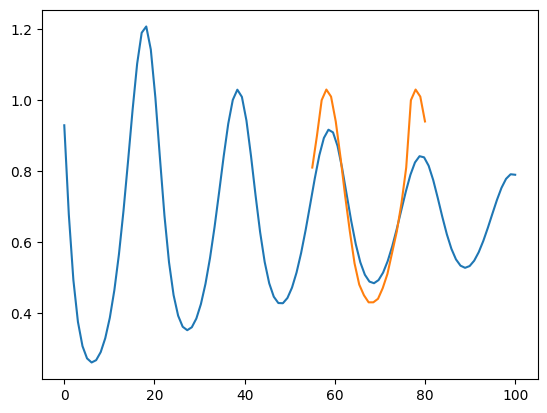

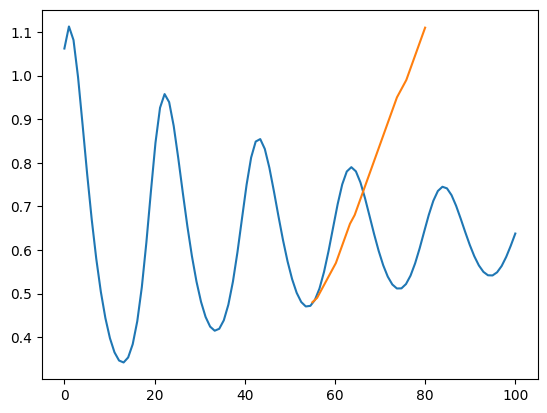

In [5]:
N_FORECAST = 25
plt.plot(torch.linspace(0, 100, 100), test_trajectories[3, :, 0])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 0])
plt.show()

plt.plot(torch.linspace(0, 100, 100), test_trajectories[3, :, 1])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), future_points[0, :, 1])
plt.show()

In [51]:
future_points = gen_points(model, test_trajectories[:, :80], n_points=20, decimals=2)

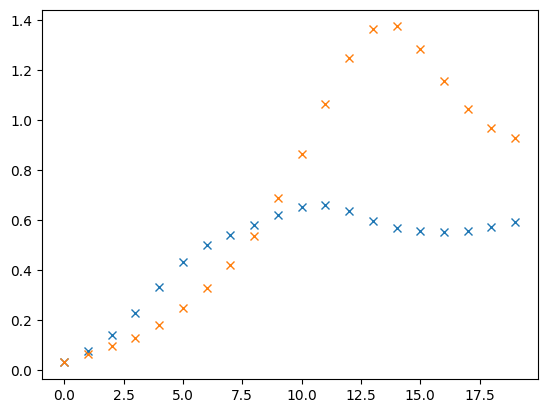

In [52]:
pred_maes, prey_maes, pred_mraes, prey_mraes = compute_metrics(test_trajectories[:, 80:], future_points)

plt.plot(torch.linspace(0, 19, 20), pred_mraes, "x")
plt.plot(torch.linspace(0, 19, 20), prey_mraes, "x")
plt.show()